## Load the Adult Data

In [19]:
## If Running in google colab
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
dir_path = '/content/drive/MyDrive/CSE_248/'


In [22]:
!pip install torchattacks

In [2]:
import numpy as np
import torch
import torchattacks
from torch.utils.data import TensorDataset, DataLoader



Load the MNIST dataset as numpy array.

In [3]:
from sklearn import datasets
mnist = datasets.load_digits()


In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [5]:
mnist['data'].shape

(1797, 64)

In [6]:
mnist['target']==1

array([False,  True, False, ..., False, False, False])

In [7]:
mnist['target']==0

array([ True, False, False, ..., False, False, False])

In [8]:
z_targ = mnist['target']==0
o_targ = mnist['target']==1
features = mnist['data'][[a or b for a, b in zip(z_targ, o_targ)]]
label = mnist['target'][[a or b for a, b in zip(z_targ, o_targ)]]

Load the numpy array as torch tensors.

In [9]:
print(features.shape, label.shape)

import torchvision
mean = np.mean(features, axis=0)
std = np.std(features, axis=0)

transforms=torchvision.transforms.Normalize(mean=mean, std=std)
print(mean, std)
# torchvision.transforms.Normalize(
#       [, meanOfChannel2, meanOfChannel3] 
#     , [stdOfChannel1, stdOfChannel2, stdOfChannel3] 
# )

(360, 64) (360,)
[0.00000000e+00 1.66666667e-02 3.31111111e+00 1.11305556e+01
 1.08472222e+01 4.51944444e+00 5.19444444e-01 0.00000000e+00
 0.00000000e+00 4.86111111e-01 8.27500000e+00 1.30638889e+01
 1.27333333e+01 9.89444444e+00 1.08611111e+00 0.00000000e+00
 5.55555556e-03 2.40277778e+00 1.06250000e+01 1.01138889e+01
 8.20000000e+00 9.75277778e+00 2.09444444e+00 0.00000000e+00
 2.77777778e-03 3.69166667e+00 1.08750000e+01 8.20833333e+00
 7.07777778e+00 7.64166667e+00 3.37500000e+00 0.00000000e+00
 0.00000000e+00 3.48611111e+00 9.16666667e+00 6.44166667e+00
 6.94444444e+00 7.14444444e+00 3.70555556e+00 0.00000000e+00
 0.00000000e+00 1.94722222e+00 9.18611111e+00 6.01666667e+00
 7.53888889e+00 8.56388889e+00 3.07222222e+00 0.00000000e+00
 0.00000000e+00 4.52777778e-01 8.85555556e+00 1.04583333e+01
 1.19805556e+01 1.04416667e+01 2.23055556e+00 3.25000000e-01
 0.00000000e+00 5.55555556e-03 3.18888889e+00 1.13250000e+01
 1.31750000e+01 7.02500000e+00 1.67777778e+00 7.55555556e-01] [0.   

In [10]:
SEED = 0
BATCH_SIZE = 128 



# generate the training data index and validation data index
np.random.seed(SEED)
random_index = np.random.rand(len(features))  
random_index = np.argsort(random_index)
train_index = random_index[: int(len(features)*0.8)]  # 80% data for training
val_index = random_index[int(len(features)*0.8):]


# generate the training data and validation data
train_data = features[train_index]
train_label = label[train_index]
val_data = features[val_index]
val_label = label[val_index]
print('The training data has the size of {} and the val has the size of {}'.format(str(len(train_data)), str(len(val_data))))


# prepare the dataloader
train_dataset = TensorDataset(torch.Tensor(train_data).float(), torch.Tensor(train_label))
val_dataset = TensorDataset(torch.Tensor(val_data).float(), torch.Tensor(val_label))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=0) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0, drop_last=False)



The training data has the size of 288 and the val has the size of 72


In [12]:
import torch.nn as nn
from torch.nn.functional import normalize

# prepare our network
class my_net(nn.Module):
    def __init__(self, input_dim=64, emb_dim=64, mlp_ratio=4, num_classes=2): 
        super().__init__()  
        
        self.embedding = nn.Linear(input_dim, emb_dim)
        self.block1 = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*mlp_ratio),
             nn.GELU(),
             nn.Linear(emb_dim*mlp_ratio, emb_dim),
             )
        self.block2 = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*mlp_ratio),
             nn.GELU(),
             nn.Linear(emb_dim*mlp_ratio, emb_dim),
             )
        self.cls = nn.Sequential(
             nn.LayerNorm(emb_dim),
             nn.Linear(emb_dim,  num_classes) 
        )
    
    def forward(self, x):
        
        x = self.embedding(x)
        x = self.block1(x)             
        x = self.cls(x)
        
        return x


def topk(output, target, ks=(1,)):
    """Returns one boolean vector for each k, whether the target is within the output's top-k."""
    batch_size = output.size(0)
    _, pred = output.topk(max(ks), 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [correct[:k].max(0)[0].float().mean() for k in ks]

def normalization(tensor):
    return normalize(tensor, p=2.0, dim = 0)

In [86]:
LR = 0.1
NUM_EPOCH = 40
LOG_STEP = 200


our_net = my_net()
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(our_net.parameters(), lr=LR, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=NUM_EPOCH)

train_all_loss = []
val_all_loss = []
train_acc = []
val_acc = []

for epoch in range(NUM_EPOCH):
    our_net.train()
    avg_top1 = []
    for batch_id, (train_sample, train_labels) in enumerate(train_loader):   
        
        train_labels = train_labels.long()
        # output = our_net(normalization(train_sample, mean=mean, std=std))
        output = our_net(normalization(train_sample))
        loss = criterion(output, train_labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_all_loss.append(loss.item())
        top1 = topk(output, train_labels, ks=(1,))
        avg_top1.extend(top1)
        if batch_id % LOG_STEP ==0:
            print('Epoch {} Current Step {}/{}: loss is {losses:.6f}'
                  .format(str(epoch) ,str(batch_id), str(len(train_loader)), losses = loss.item()))
    train_acc.append(np.mean(avg_top1))
    our_net.eval()
    avg_top1 = []
    with torch.no_grad():
        for  batch_id, (val_sample, val_labels) in enumerate(val_loader):
            val_labels = val_labels.long()
            # outputs = our_net(normalization(val_sample, mean=mean, std=std).float())
            outputs = our_net(normalization(val_sample))
            loss = criterion(outputs, val_labels)
            val_all_loss.append(loss.item())
            top1 = topk(outputs, val_labels, ks=(1,))
            avg_top1.extend(top1)
        print('------------------------------------------------')
        print('Epoch {} Validation acc is {top1:.6f}'
                  .format(str(epoch), top1 = np.mean(avg_top1)))
    val_acc.append(np.mean(avg_top1))
        
        

Epoch 0 Current Step 0/3: loss is 0.920116
------------------------------------------------
Epoch 0 Validation acc is 0.416667
Epoch 1 Current Step 0/3: loss is 3.498508
------------------------------------------------
Epoch 1 Validation acc is 0.583333
Epoch 2 Current Step 0/3: loss is 2.351151
------------------------------------------------
Epoch 2 Validation acc is 0.416667
Epoch 3 Current Step 0/3: loss is 1.635259
------------------------------------------------
Epoch 3 Validation acc is 0.583333
Epoch 4 Current Step 0/3: loss is 0.921628
------------------------------------------------
Epoch 4 Validation acc is 0.416667
Epoch 5 Current Step 0/3: loss is 0.734901
------------------------------------------------
Epoch 5 Validation acc is 0.416667
Epoch 6 Current Step 0/3: loss is 0.651293
------------------------------------------------
Epoch 6 Validation acc is 0.583333
Epoch 7 Current Step 0/3: loss is 0.757719
------------------------------------------------
Epoch 7 Validation 

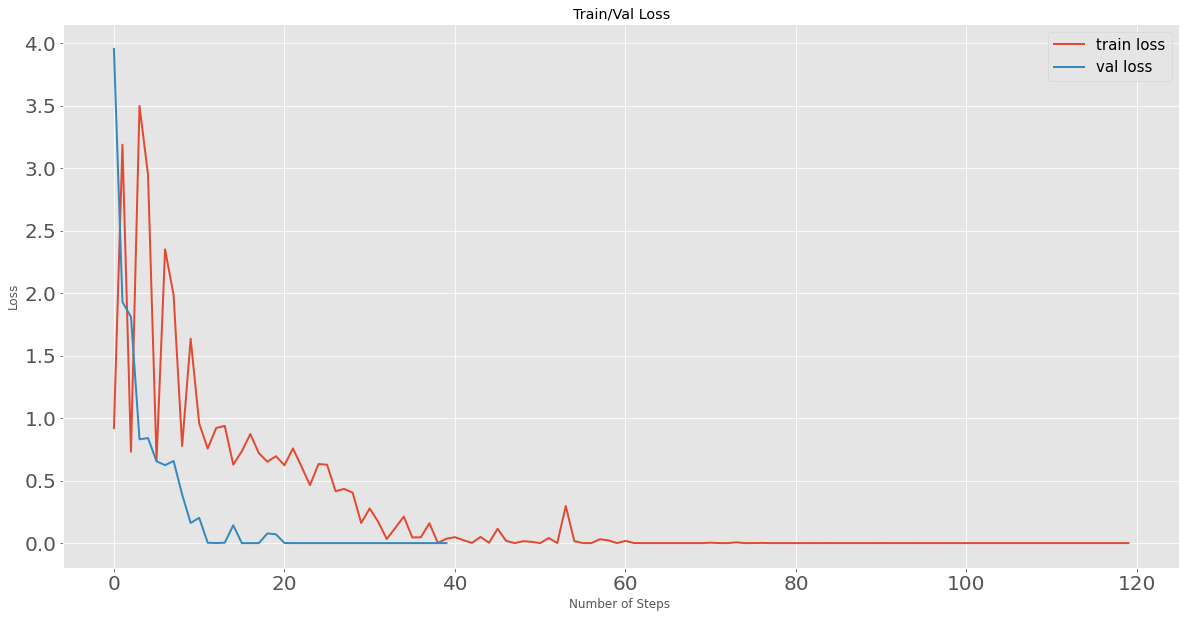

In [87]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os


# plot the loss and acc
def plot_loss_fig(train_loss, val_loss):
    myparams = {

   'axes.labelsize': '20',

   'xtick.labelsize': '20',

   'ytick.labelsize': '20',

   'lines.linewidth': 2,

   'legend.fontsize': '15',

   'font.family': 'Times New Roman',
}

    pylab.rcParams.update(myparams) 

    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,10))

    plt.plot(range(len(train_loss)), train_loss, label = 'train loss')
    plt.plot(range(len(val_loss)), val_loss, label = 'val loss')
    
    plt.grid(True)  # add grid
    plt.legend()
    plt.title("Train/Val Loss")  
    plt.ylabel('Loss') 
    plt.xlabel('Number of Steps ')
plot_loss_fig(train_all_loss, val_all_loss)

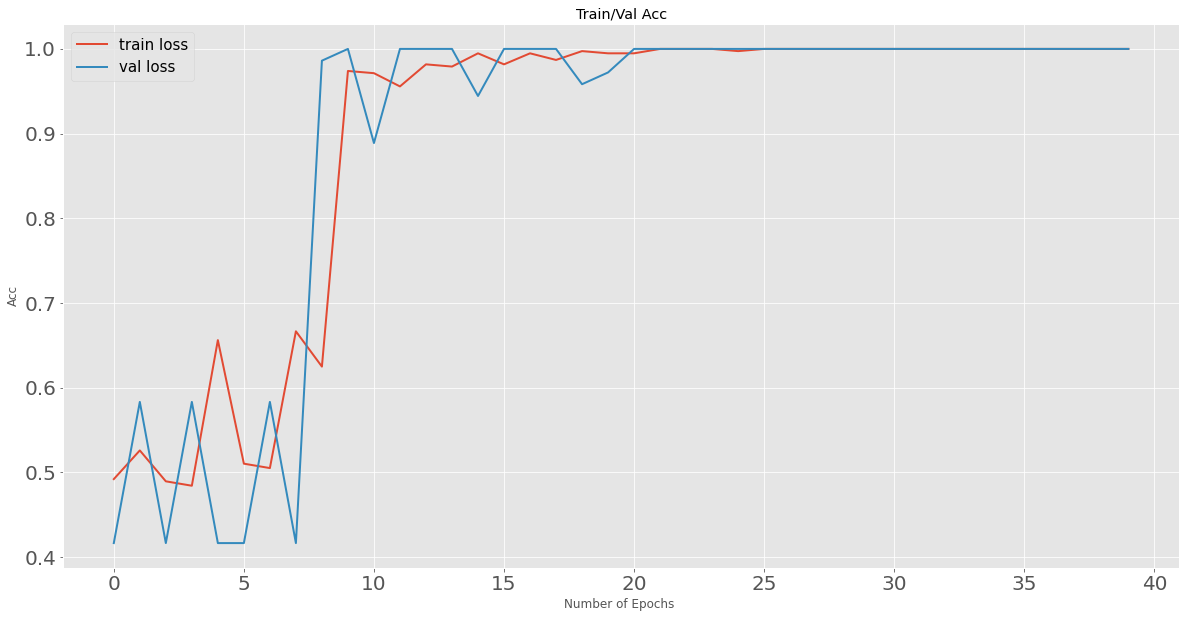

In [88]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os


# plot the acc and acc
def plot_acc_fig(train_acc, val_acc):
    myparams = {

   'axes.labelsize': '20',

   'xtick.labelsize': '20',

   'ytick.labelsize': '20',

   'lines.linewidth': 2,

   'legend.fontsize': '15',

   'font.family': 'Times New Roman',
}

    pylab.rcParams.update(myparams) 

    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,10))

    plt.plot(range(len(train_acc)), train_acc, label = 'train loss')
    plt.plot(range(len(val_acc)), val_acc, label = 'val loss')
    
    plt.grid(True)  # add grid
    plt.legend()
    plt.title("Train/Val Acc")  
    plt.ylabel('Acc') 
    plt.xlabel('Number of Epochs ')
plot_acc_fig(train_acc, val_acc)

In [89]:
torch.save(our_net.state_dict(), dir_path+'naturally_trained_model_mnist.pt')

# Adversarial Training Procedure


In [119]:
import copy 

LR = 0.01
NUM_EPOCH = 200
LOG_STEP = 200

adv_net = my_net()
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(adv_net.parameters(), lr=LR, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=NUM_EPOCH)

train_all_loss = []
val_all_loss = []
train_acc = []
val_acc = []

attacker = torchattacks.PGD(adv_net, eps=16/255, alpha=2/255, steps=20, random_start=True)
for epoch in range(NUM_EPOCH):
    adv_net.train()
    avg_top1 = []
    for batch_id, (train_sample, train_labels) in enumerate(train_loader): 
        train_labels = train_labels.long()
        # Generate adv. examples to mix in 
        atk_inds = np.random.choice(range(train_sample.shape[0]), size=train_sample.shape[0], replace=False)
        orig_inds = [ind for ind in range(train_sample.shape[0]) if ind not in atk_inds]
        #adv_samples = attacker(normalization(train_sample[atk_inds], mean=mean, std=std).float(), train_labels[atk_inds])
        adv_samples = attacker(normalization(train_sample[atk_inds]), train_labels[atk_inds])
        orig_samples = train_sample[orig_inds]
        mixed_set = torch.cat((adv_samples, orig_samples))
        mixed_labels = torch.cat((train_labels[atk_inds], train_labels[orig_inds]))
        
        # output = adv_net(normalization(mixed_set, mean=mean, std=std).float())
        output = adv_net(normalization(mixed_set).float())
        loss = criterion(output, mixed_labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_all_loss.append(loss.item())
        top1 = topk(output, train_labels, ks=(1,))
        avg_top1.extend(top1)
        if batch_id % LOG_STEP ==0:
            print('Epoch {} Current Step {}/{}: loss is {losses:.6f}'
                  .format(str(epoch) ,str(batch_id), str(len(train_loader)), losses = loss.item()))
    train_acc.append(np.mean(avg_top1))
    adv_net.eval()
    avg_top1 = []
    with torch.no_grad():
        for  batch_id, (val_sample, val_labels) in enumerate(val_loader):
            val_labels = val_labels.long()
            # outputs = adv_net(normalization(val_sample, mean=mean, std=std).float())
            outputs = adv_net(normalization(val_sample).float())
            loss = criterion(outputs, val_labels)
            val_all_loss.append(loss.item())
            top1 = topk(outputs, val_labels, ks=(1,))
            avg_top1.extend(top1)
        print('------------------------------------------------')
        print('Epoch {} Validation acc is {top1:.6f}'
                  .format(str(epoch), top1 = np.mean(avg_top1)))
    val_acc.append(np.mean(avg_top1))

Epoch 0 Current Step 0/3: loss is 1.187668
------------------------------------------------
Epoch 0 Validation acc is 0.819444
Epoch 1 Current Step 0/3: loss is 0.789829
------------------------------------------------
Epoch 1 Validation acc is 0.583333
Epoch 2 Current Step 0/3: loss is 0.793104
------------------------------------------------
Epoch 2 Validation acc is 0.416667
Epoch 3 Current Step 0/3: loss is 0.787252
------------------------------------------------
Epoch 3 Validation acc is 0.847222
Epoch 4 Current Step 0/3: loss is 0.742940
------------------------------------------------
Epoch 4 Validation acc is 0.777778
Epoch 5 Current Step 0/3: loss is 0.738191
------------------------------------------------
Epoch 5 Validation acc is 0.416667
Epoch 6 Current Step 0/3: loss is 0.714114
------------------------------------------------
Epoch 6 Validation acc is 0.694444
Epoch 7 Current Step 0/3: loss is 0.715536
------------------------------------------------
Epoch 7 Validation 

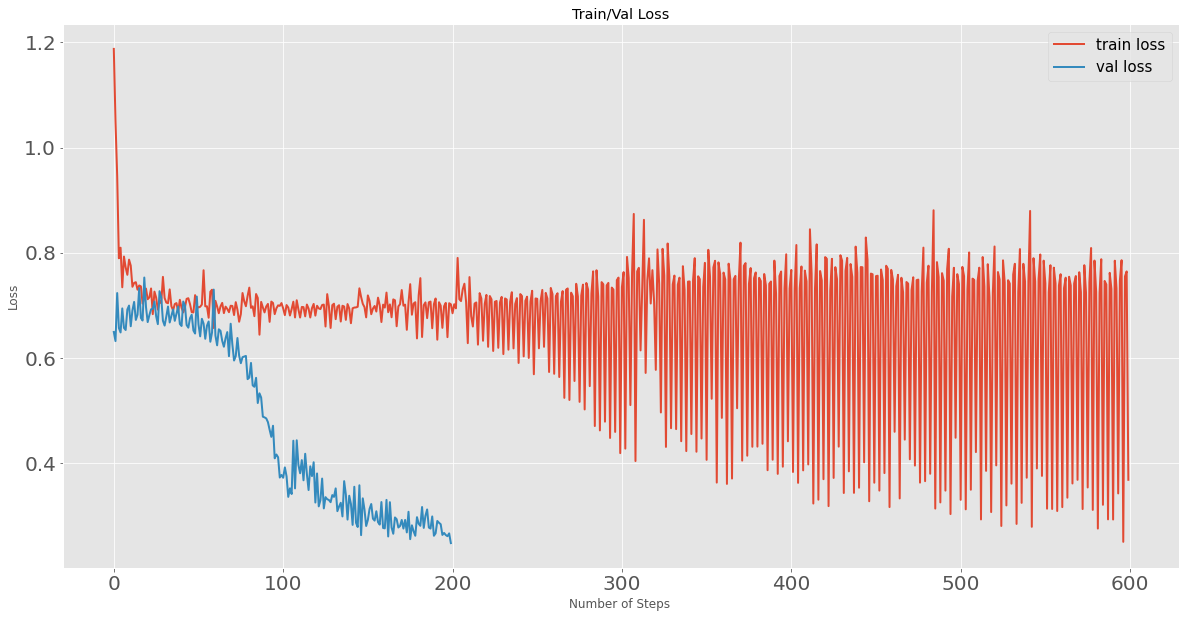

In [120]:
plot_loss_fig(train_all_loss, val_all_loss)

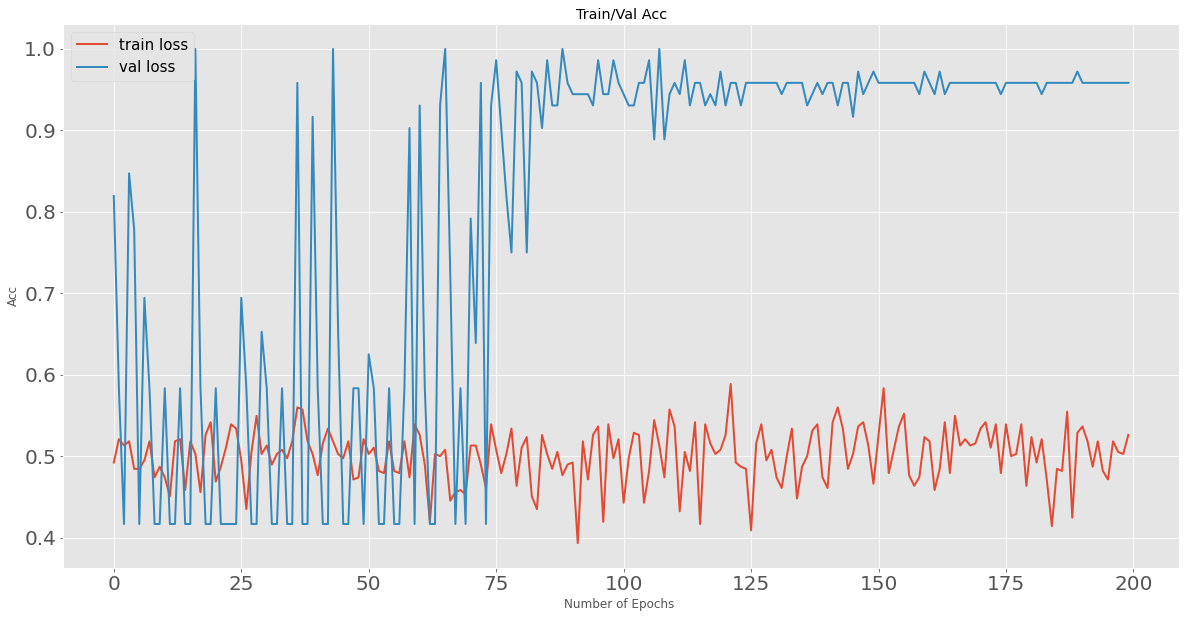

In [121]:
plot_acc_fig(train_acc, val_acc)

In [122]:
from torch import unsqueeze
num_wrong_nat = 0
num_attempt_nat = 0
num_wrong_adv = 0
num_attempt_adv = 0
for batch_id, (train_sample, train_labels) in enumerate(val_loader):
    for j in range(train_sample.shape[0]):
        instance = unsqueeze(train_sample[j], 0)
        label = unsqueeze(train_labels[j], 0)

        attacker_nat = torchattacks.PGD(our_net, eps=8/255, alpha=2/255, steps=20, random_start=True)
        adv_image = attacker_nat(normalization(instance).float(), label.long())
        model_guess_nat = our_net(normalization(instance).float()).max(1).indices
        adv_guess_nat = our_net(normalization(adv_image).float()).max(1).indices
        if model_guess_nat !=  adv_guess_nat:
            num_wrong_nat += 1
        num_attempt_nat += 1

        attacker_adv = torchattacks.PGD(adv_net, eps=8/255, alpha=2/255, steps=20, random_start=True)
        adv_image = attacker_adv(normalization(instance).float(), label.long())
        model_guess_adv = adv_net(normalization(instance).float()).max(1).indices
        adv_guess_adv = adv_net(normalization(adv_image).float()).max(1).indices
        if model_guess_adv !=  adv_guess_adv:
            num_wrong_adv += 1
        num_attempt_adv += 1

print('Number Incorrect (natural model): {}'.format(num_wrong_nat))
print('Number Attempted (natural model): {}'.format(num_attempt_nat))

print('Number Incorrect (adversarially trained model): {}'.format(num_wrong_adv))
print('Number Attempted (adversarially trained model): {}'.format(num_attempt_adv))

Number Incorrect (natural model): 40
Number Attempted (natural model): 72
Number Incorrect (adversarially trained model): 28
Number Attempted (adversarially trained model): 72


In [124]:
torch.save(adv_net.state_dict(), dir_path+'adversarially_trained_model_mnist.pt')

# Recourse Generation


In [ ]:
! pip install carla-recourse

In [13]:
nat_model_state = torch.load('naturally_trained_model_mnist.pt')
nat_model = my_net()
nat_model.load_state_dict(nat_model_state)

adv_model_state = torch.load('adversarially_trained_model_mnist.pt')
adv_model = my_net()
adv_model.load_state_dict(adv_model_state)


<All keys matched successfully>

In [14]:
feature_cols = mnist['feature_names']

In [15]:
import pandas as pd
df = pd.DataFrame(normalization(torch.tensor(features)).detach().numpy(), columns=feature_cols)
df['Income_Greater_50k'] = label
df['Income_Greater_50k'] = df['Income_Greater_50k'].astype(int)
df.head()


,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,Income_Greater_50k
0,0.0,0.0,0.056219,0.056372,0.040921,0.007898,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.071317,0.055468,0.039033,0.000000,0.000000,0.0,0
1,0.0,0.0,0.000000,0.052036,0.059107,0.039488,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.046934,0.062453,0.059330,0.000000,0.0,1
2,0.0,0.0,0.011244,0.039027,0.068201,0.086873,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.011886,0.042668,0.050743,0.017799,0.000000,0.0,0
3,0.0,0.0,0.000000,0.000000,0.063654,0.102668,0.031702,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.004267,0.050743,0.094927,0.011861,0.0,1
4,0.0,0.0,0.033731,0.056372,0.050014,0.055283,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.023772,0.051201,0.050743,0.023732,0.000000,0.0,0


In [16]:
SEED = 0
BATCH_SIZE = 128 



# generate the training data index and validation data index
np.random.seed(SEED)
random_index = np.random.rand(len(features))  
random_index = np.argsort(random_index)
train_index = random_index[: int(len(features)*0.8)]  # 80% data for training
val_index = random_index[int(len(features)*0.8):]


# generate the training data and validation data
train_data_df = df.iloc[train_index]
val_data_df = df.iloc[val_index]


In [17]:
from carla import Data

# Custom data set implementations need to inherit from the Data interface
class IncomeDataset(Data):

    def __init__(self, data, train, val, feature_cols):
        # The data set can e.g. be loaded in the constructor
        self._dataset = data
        self._train = train
        self._val = val
        self.feature_cols = feature_cols

    # List of all categorical features
    @property
    def categorical(self):
        return []

    # List of all continuous features
    @property
    def continuous(self):
        return feature_cols

    # List of all immutable features which
    # should not be changed by the recourse method
    @property
    def immutables(self):
        return []

    # Feature name of the target column
    @property
    def target(self):
        return 'Income_Greater_50k'
    
    @property
    def df(self):
        return self._dataset
        pass

    @property
    def df_train(self):
        return self._train

    @property
    def df_test(self):
        return self._val

    def transform(self, df):
        new_vals = normalization(df.values, self._mean, self._std)
        return pd.DataFrame(new_vals, columns=self._dataset.columns)

    def inverse_transform(self, df):
        new_vals = inverse_normalization(df.values, self._mean, self._std)
        return pd.DataFrame(new_vals, columns=self._dataset.columns)
    
    def normalization(tensor, mean, std):
        return ((tensor - mean) / std).float()
    
    def inverse_normalization(x, mean, std):
        return (x*std)+mean
    
ds = IncomeDataset(df, train_data_df, val_data_df, feature_cols)

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/f

[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


In [18]:
from carla import MLModel

# Custom black-box models need to inherit from
# the MLModel interface
class MyOwnModel(MLModel):
    def __init__(self, data, model, feature_cols):
        super().__init__(data)
        # The constructor can be used to load or build an
        # arbitrary black-box-model
        self._mymodel = model
        self.feature_cols = feature_cols

    # List of the feature order the ml model was trained on
    @property
    def feature_input_order(self):
        return self.feature_cols
    # The ML framework the model was trained on
    @property
    def backend(self):
        return "pytorch"

    # The black-box model object
    @property
    def raw_model(self):
        return self._mymodel

    # The predict function outputs
    # the continuous prediction of the model
    def predict(self, x):
        if isinstance(x, np.ndarray):
            x = torch.Tensor(x)
        elif isinstance(x, pd.DataFrame):
            x = torch.Tensor(x.values)
        return self._mymodel(x).max(1).indices

    # The predict_proba method outputs
    # the prediction as class probabilities
    def predict_proba(self, x):
        if isinstance(x, np.ndarray):
            x = torch.Tensor(x)
        elif isinstance(x, pd.DataFrame):
            x = torch.Tensor(x.values)
        logits = self._mymodel(x)
        probs = torch.nn.functional.softmax(logits, dim=1)
        return probs.detach().numpy()
    
nat_model_carla = MyOwnModel(ds, nat_model, feature_cols)
adv_model_carla = MyOwnModel(ds, adv_model, feature_cols)

In [19]:
#from carla import OnlineCatalog, MLModelCatalog
from carla.recourse_methods import GrowingSpheres

# # get factuals from the data to generate counterfactual examples
factuals = ds.df

# # load a recourse model and pass black box model
gs_1 = GrowingSpheres(nat_model_carla)

# # generate counterfactual examples
counterfactuals_1 = gs_1.get_counterfactuals(factuals)

# # load a recourse model and pass black box model
gs_2 = GrowingSpheres(adv_model_carla)

# # generate counterfactual examples
counterfactuals_2 = gs_2.get_counterfactuals(factuals)


In [20]:
factuals

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,...,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,Income_Greater_50k
0,0.0,0.0,0.056219,0.056372,0.040921,...,0.039033,0.000000,0.000000,0.0,0
1,0.0,0.0,0.000000,0.052036,0.059107,...,0.062453,0.059330,0.000000,0.0,1
2,0.0,0.0,0.011244,0.039027,0.068201,...,0.050743,0.017799,0.000000,0.0,0
3,0.0,0.0,0.000000,0.000000,0.063654,...,0.050743,0.094927,0.011861,0.0,1
4,0.0,0.0,0.033731,0.056372,0.050014,...,0.050743,0.023732,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
355,0.0,0.0,0.011244,0.052036,0.045467,...,0.046840,0.059330,0.000000,0.0,1
356,0.0,0.0,0.089950,0.052036,0.050014,...,0.046840,0.041531,0.000000,0.0,1
357,0.0,0.0,0.056219,0.069381,0.045467,...,0.062453,0.047464,0.011861,0.0,0
358,0.0,0.0,0.067463,0.052036,0.054561,...,0.039033,0.023732,0.000000,0.0,1


In [21]:
sum(factuals['Income_Greater_50k']==1)

182

In [22]:
counterfactuals_1

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,...,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,Income_Greater_50k
0,-0.035814,0.029500,0.039840,0.006716,0.034521,...,0.001591,0.004209,0.007193,0.018580,1.0
1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
2,-0.017755,0.020394,0.042232,0.073438,0.058927,...,0.053524,0.032450,-0.016101,0.026651,1.0
3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
4,0.038217,0.085426,0.006062,0.038547,0.096315,...,0.017478,0.001574,-0.011549,0.002887,1.0
...,...,...,...,...,...,...,...,...,...,...,...
355,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
356,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
357,0.005472,0.001703,0.051472,0.051645,0.045986,...,0.072518,0.049526,0.033992,-0.030046,1.0
358,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN


In [23]:
counterfactuals_2

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,...,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,Income_Greater_50k
0,0.016625,0.002213,0.053804,0.031427,0.061996,...,-0.009914,-0.053396,0.047499,0.085197,1.0
1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
2,-0.001740,0.005977,-0.068165,0.053351,-0.048530,...,0.112356,0.011885,-0.049018,0.080475,1.0
3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
4,0.024893,0.110888,0.022472,0.044603,0.019754,...,-0.000861,-0.009192,0.037574,0.017920,1.0
...,...,...,...,...,...,...,...,...,...,...,...
355,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
356,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
357,0.100079,0.060570,0.136893,0.014068,0.069958,...,-0.003357,0.073205,0.028445,0.035249,1.0
358,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN


In [80]:
factuals.shape[0]-sum(factuals['Income_Greater_50k']==1)

178

In [81]:
sum(counterfactuals_1['pixel_0_0'].notnull())

178

In [82]:
sum(counterfactuals_1['pixel_0_0'].notnull())/(factuals.shape[0]-sum(factuals['Income_Greater_50k']==1))

1.0

In [83]:
sum(counterfactuals_2['pixel_0_0'].notnull())/(factuals.shape[0]-sum(factuals['Income_Greater_50k']==1))

1.3202247191011236

In [45]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from typing import List

from carla.models.api import MLModel
from carla.recourse_methods.api import RecourseMethod
from carla.evaluation.distances import get_distances


def yNN_manifold(
    factuals: Data,
    counterfactuals: pd.DataFrame,
    recourse_method: RecourseMethod,
    mlmodel: MLModel,
    y: int = 10,
    dist_type: int =1,
)-> List[float]:
    """
    TODO
    Parameters
    ----------
    counterfactuals: Generated counterfactual examples
    recourse_method: Method we want to benchmark
    y: Number of

    Returns
    -------
    List[List[float]]
    """
    distances = []
    N = counterfactuals.shape[0]

    positive_class = factuals.df.loc[factuals.df.index[factuals.df[factuals.target]==1]]
    
    nbrs = NearestNeighbors(n_neighbors=y).fit(positive_class.values)

    for i, row in counterfactuals.iterrows():
        if pd.isna(row).any():
            distances.append(np.nan)
            continue
        knn = nbrs.kneighbors(row.values.reshape((1, -1)), y, return_distance=False)[0]
        distances_local = 0
        
        for idx in knn:
            neighbour = positive_class.iloc[idx]
            neighbour = neighbour.drop(mlmodel.data.target)
            neighbour = neighbour.values.reshape((1, -1))
            row_copy = row.drop(mlmodel.data.target)
            row_copy = row_copy.values.reshape((1, -1))
            
            distances_local += get_distances(row_copy, neighbour)[0][dist_type]
        distances.append((1 / y) * distances_local)
    return distances

def sphere_manifold(
    factuals: Data,
    counterfactuals: pd.DataFrame,
    recourse_method: RecourseMethod,
    mlmodel: MLModel,
    sphere_factor: float = 0.8,
    dist_type: int = 2,
)-> List[List[float]]:
    """
    TODO
    Parameters
    ----------
    counterfactuals: Generated counterfactual examples
    recourse_method: Method we want to benchmark
    y: Number of

    Returns
    -------
    List[List[float]]
    """
    distances = []
    N = counterfactuals.shape[0]

    positive_class = factuals.df.loc[factuals.df.index[factuals.df[factuals.target]==1]]
    
    for i, row in counterfactuals.iterrows():
        if pd.isna(row).any():
            distances.append(np.nan)
            continue
        all_deltas = np.asarray(factuals.df.drop(mlmodel.data.target, axis=1) - row.drop(mlmodel.data.target))
        all_dists = np.sum(np.square(np.abs(all_deltas)), axis=1, dtype=np.float)
        all_euc_dist = np.sqrt(all_dists)
        radius = np.mean(all_euc_dist)*sphere_factor

        pos_deltas = np.asarray(positive_class.drop(mlmodel.data.target, axis=1) - row.drop(mlmodel.data.target))
        pos_dists = np.sum(np.square(np.abs(pos_deltas)), axis=1, dtype=np.float)
        pos_euc_dist = np.sqrt(pos_dists)
        relevant_neighbors = np.where(pos_euc_dist < radius)[0]
        #print(relevant_neighbors)
        if len(relevant_neighbors) == 0:
            distances.append(np.nan)
        else:
            relevant_distances = pos_euc_dist[relevant_neighbors]
            distances.append(np.mean(relevant_distances))
        
    return distances



In [46]:
ynn_1 = yNN_manifold(ds, counterfactuals_1, gs_1, nat_model_carla)
ynn_2 = yNN_manifold(ds, counterfactuals_2, gs_2, adv_model_carla)


In [47]:
sphere_1 = sphere_manifold(ds, counterfactuals_1, gs_1, nat_model_carla)
sphere_2 = sphere_manifold(ds, counterfactuals_2, gs_2, adv_model_carla)


In [27]:
ynn_1 = [val for val in ynn_1 if not pd.isnull(val)]
ynn_2 = [val for val in ynn_2 if not pd.isnull(val)]


In [28]:
np.mean(ynn_1)

2.353357767815421

In [29]:
np.mean(ynn_2)

2.6282805039590342

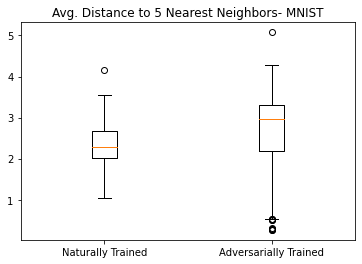

In [30]:
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot([ynn_1, ynn_2])
plt.title('Avg. Distance to 5 Nearest Neighbors- MNIST')
plt.xticks([1, 2], ['Naturally Trained', 'Adversarially Trained'])
plt.show()

In [31]:
sphere_1 = [val for val in sphere_1 if not pd.isnull(val)]
sphere_2 = [val for val in sphere_2 if not pd.isnull(val)]


In [32]:
np.mean(sphere_1)

0.29254440784846625

In [33]:
np.mean(sphere_2)

0.2760134906213657

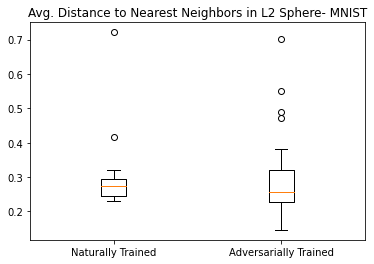

In [34]:
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot([sphere_1, sphere_2])
plt.title('Avg. Distance to Nearest Neighbors in L2 Sphere- MNIST')
plt.xticks([1, 2], ['Naturally Trained', 'Adversarially Trained'])
plt.show()

In [52]:
def dist(
    factuals: Data,
    counterfactuals: pd.DataFrame,
    recourse_method: RecourseMethod,
    mlmodel: MLModel,
    y: int = 5,
    dist_type: int = 1,
)-> List[float]:
    """
    TODO
    Parameters
    ----------
    counterfactuals: Generated counterfactual examples
    recourse_method: Method we want to benchmark
    y: Number of

    Returns
    -------
    List[List[float]]
    """
    distances = []
    N = counterfactuals.shape[0]

    for i, row in counterfactuals.iterrows():
        if pd.isna(row).any():
            distances.append(np.nan)
            continue
            
        original = factuals.df.drop(mlmodel.data.target, axis=1).iloc[i].values.reshape((1,-1))
        
        row_copy = row.drop(mlmodel.data.target)
        row_copy = row_copy.values.reshape((1, -1))
        distances.append(get_distances(row_copy, original)[0][dist_type])
    return distances

dist_1 = dist(ds, counterfactuals_1, gs_1, nat_model_carla)
dist_2 = dist(ds, counterfactuals_2, gs_2, adv_model_carla)



In [36]:
dist_1 = [val for val in dist_1 if not pd.isnull(val)]
dist_2 = [val for val in dist_2 if not pd.isnull(val)]


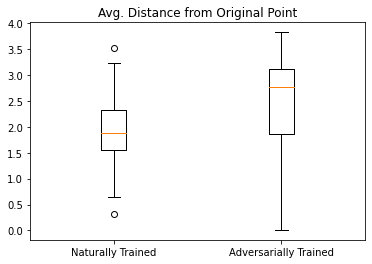

In [37]:
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot([dist_1, dist_2])
plt.title('Avg. Distance from Original Point')
plt.xticks([1, 2], ['Naturally Trained', 'Adversarially Trained'])
plt.show()

In [53]:
len(dist_1)

360

In [54]:
len(ynn_1)

360

Text(0, 0.5, 'Proximity to Positive Manifold')

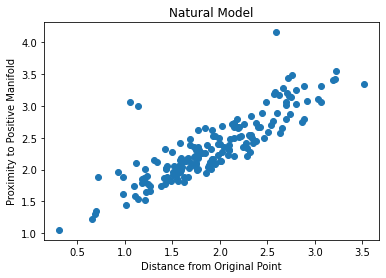

In [55]:
plt.scatter(dist_1, ynn_1)
plt.title('Natural Model')
plt.xlabel('Distance from Original Point')
plt.ylabel('Proximity to Positive Manifold')

Text(0, 0.5, 'Proximity to Positive Manifold')

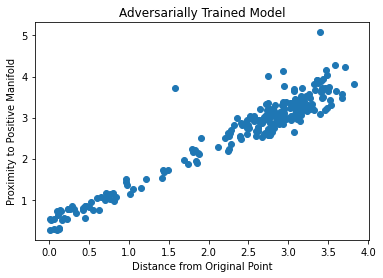

In [56]:
plt.scatter(dist_2, ynn_2)
plt.title('Adversarially Trained Model')
plt.xlabel('Distance from Original Point')
plt.ylabel('Proximity to Positive Manifold')

Text(0, 0.5, 'Proximity to Positive Manifold')

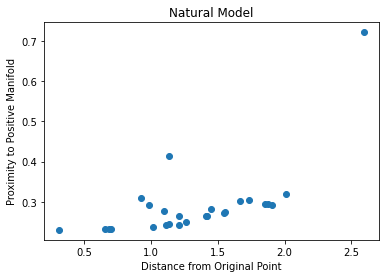

In [57]:
plt.scatter(dist_1, sphere_1)
plt.title('Natural Model')
plt.xlabel('Distance from Original Point')
plt.ylabel('Proximity to Positive Manifold')

Text(0, 0.5, 'Proximity to Positive Manifold')

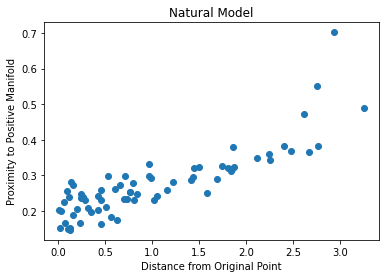

In [58]:
plt.scatter(dist_2, sphere_2)
plt.title('Natural Model')
plt.xlabel('Distance from Original Point')
plt.ylabel('Proximity to Positive Manifold')

In [ ]:
#from carla import OnlineCatalog, MLModelCatalog
from carla.recourse_methods import GrowingSpheres

# load a catalog dataset
data_name = "adult"
dataset = OnlineCatalog(data_name)

dataset.raw

# load artificial neural network from catalog
model = MLModelCatalog(dataset, "ann")

# get factuals from the data to generate counterfactual examples
factuals = dataset.raw.iloc[:10]

# load a recourse model and pass black box model
gs = GrowingSpheres(model)

# generate counterfactual examples
counterfactuals = gs.get_counterfactuals(factuals)


NameError: ignored

In [ ]:
factuals = 
gs = GrowingSpheres(our_net)

# generate counterfactual examples
counterfactuals = gs.get_counterfactuals(factuals)